# GPU Regressions
by Martin Popovski

Data: https://www.kaggle.com/iliassekkaf/computerparts?select=All_GPUs.csv

## Data cleaning

In [1]:
import pandas as pd
import math
import re

In [2]:
df1 = pd.read_csv('data/All_GPUs.csv')

In [3]:
df1

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,Process,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection
0,Tesla G92b,NaN,NaN,738 MHz,2.0,Yes,DX 10.0,NaN,0.0,No,...,55nm,16,\n01-Mar-2009,NaN,2560x1600,Yes,4.0,64.0,47 GTexel/s,0.0
1,R600 XT,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n14-May-2007,NaN,2560x1600,Yes,4.0,16.0,12 GTexel/s,0.0
2,R600 PRO,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n07-Dec-2007,NaN,2560x1600,Yes,4.0,16.0,10 GTexel/s,0.0
3,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n01-Jul-2007,NaN,2560x1600,Yes,4.0,8.0,7 GTexel/s,0.0
4,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n28-Jun-2007,NaN,2560x1600,Yes,4.0,8.0,6 GTexel/s,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,MCP61,NaN,NaN,\n-,1.0,No,DX 9.0c,NaN,1.0,Yes,...,NaN,NaN,\n01-Jun-2006,NaN,2560x1600,No,3.0,NaN,NaN,1.0
3402,MCP61,NaN,NaN,\n-,0.0,No,DX 9.0c,NaN,0.0,Yes,...,NaN,NaN,\n01-Jun-2006,NaN,2560x1600,No,3.0,NaN,NaN,1.0
3403,MCP51,NaN,NaN,\n-,0.0,NaN,DX 9,NaN,0.0,NaN,...,NaN,NaN,\n20-Oct-2005,NaN,NaN,No,NaN,NaN,NaN,0.0
3404,MCP51,NaN,NaN,\n-,NaN,No,DX 9.0c,NaN,0.0,Yes,...,NaN,NaN,\n01-Nov-2005,NaN,2560x1600,No,3.0,NaN,NaN,1.0


First we only take the GPUs with non null Release_Price, this reduces our row count from 3406 to 556.  

In [4]:
df2 = df1[df1['Release_Price'].notnull()].copy().reset_index(drop=True)

Most regression columns are in string form, so let's format them and convert all of them into float type.

In [5]:
def string_to_float(x):
    if isinstance(x, float) and (math.isnan(x) or math.isinf(x)):
        return None
    try:
        f = float(re.sub(r'[^0-9.]', '', x))
        if math.isnan(f) or math.isinf(f):
            return None
        return f
    except ValueError:
        return None

    
df2['Release_Price'] = df2['Release_Price'].apply(string_to_float)
df2['Boost_Clock'] = df2['Boost_Clock'].apply(string_to_float)
df2['Core_Speed'] = df2['Core_Speed'].apply(string_to_float)
df2['Texture_Rate'] = df2['Texture_Rate'].apply(string_to_float)
df2['Pixel_Rate'] = df2['Pixel_Rate'].apply(string_to_float)
df2['Max_Power'] = df2['Max_Power'].apply(string_to_float)
df2['Memory'] = df2['Memory'].apply(string_to_float)

In [6]:
def convert_memory_bandwidth(x):
    multiplier = 1
    if isinstance(x, float) and math.isnan(x):
        return None
    if x and 'MB' in x:
        multiplier = 0.001
    x = string_to_float(x)
    if x:
        return multiplier * x


df2['Memory_Bandwidth'] = df2['Memory_Bandwidth'].apply(convert_memory_bandwidth)

Extract release year from Release_Date

In [7]:
def release_date_to_year(x):
    match = re.search(r'\d+\-\w+\-(\d{4})', x)
    if match:
        return match.group(1)
    

df2['Release_Year'] = df2['Release_Date'].apply(release_date_to_year)

In [8]:
df2

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection,Release_Year
0,Pascal GP102,3840 x 2160,1531.0,NaN,1.0,NaN,DX 12,3.0,1.0,NaN,...,96,\n02-Aug-2016,1199.0,7680x4320,No,5.0,224.0,343.0,0.0,2016
1,Pascal GP102,3840 x 2160,1582.0,NaN,1.0,Yes,DX 12,3.0,1.0,No,...,24 (x4),\n06-Apr-2017,1199.0,7680x4320,Yes,5.0,56.0,354.0,0.0,2017
2,Kepler GK110-430-B1 (x2),5760 x 1600,876.0,705.0,2.0,Yes,DX 12.0,NaN,1.0,No,...,48 (x2),\n28-May-2014,2999.0,4096x2160,Yes,5.0,240.0,420.0,0.0,2014
3,Kepler GK110-430-B1 (x2),3840 x 2160,876.0,705.0,2.0,Yes,DX 12.0,NaN,1.0,No,...,48 (x2),\n28-May-2014,2999.0,4096x2160,Yes,5.0,240.0,420.0,0.0,2014
4,Maxwell GM200-400-A1,3840 x 2160,1252.0,1140.0,1.0,Yes,DX 12.1,NaN,1.0,No,...,96,\n17-Mar-2015,1099.0,4096x2160,Yes,5.0,192.0,240.0,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,Kepler GK107-425-A2,1600 x 900,NaN,993.0,2.0,Yes,DX 12.0,NaN,0.0,No,...,16,\n29-May-2014,89.0,4096x2160,No,5.0,32.0,32.0,0.0,2014
552,Kepler GK107-425-A2,1366 x 768,NaN,993.0,2.0,Yes,DX 12.0,NaN,0.0,No,...,16,\n 29-May-2014,79.0,4096x2160,No,5.0,32.0,32.0,0.0,2014
553,Kepler GK208,1366 x 768,NaN,797.0,1.0,Yes,DX 12.0,NaN,1.0,No,...,8,\n27-Mar-2014,59.0,4096x2160,No,5.0,16.0,13.0,1.0,2014
554,Kepler GK208,1366 x 768,NaN,902.0,1.0,Yes,DX 12.0,NaN,1.0,No,...,8,\n18-Jun-2014,89.0,4096x2160,No,5.0,16.0,14.0,1.0,2014


In [9]:
df2.to_csv('data/All_GPUs_clean.csv', index=False)

## Definitions

In order to better understand the data, let's take a look at the definitions of some of the attributes in this data.

The term pixel fillrate refers to the number of pixels a video card can render to screen and write to video memory in a second or in case of texture fillrate the number of texture map elements (texels) GPU can map to pixels in a second. Pixel fillrates are given in megapixels per second or in gigapixels per second (in the case of newer cards), and they are obtained by multiplying the number of Raster Output Units (ROPs) by the clock frequency of the graphics processor unit (GPU) of a video card and texture fillrate is obtained by multiplying the number of Texture Mapping Units (TMUs) by the clock frequency of the graphics processing unit (GPU). Texture fillrates are given in mega or gigatexels per second. However, there is no full agreement on how to calculate and report fillrates.

Source: https://en.wikipedia.org/wiki/Fillrate

## Visualization

### Pair plots and heat maps

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df2 = pd.read_csv('data/All_GPUs_clean.csv')

In [12]:
regression_columns = ['Release_Price', 'Boost_Clock', 'Core_Speed', 'TMUs', 'Memory', 'Memory_Bandwidth', 'Pixel_Rate', 'Texture_Rate', 'Max_Power']

In [13]:
df2[regression_columns].describe()

,Release_Price,Boost_Clock,Core_Speed,TMUs,Memory,Memory_Bandwidth,Pixel_Rate,Texture_Rate,Max_Power
count,556.000000,404.000000,477.000000,556.000000,548.000000,550.000000,556.000000,556.000000,554.000000
mean,371.562446,1358.722772,1102.014675,96.050360,4804.437956,218.221273,54.958633,141.856115,160.180505
std,698.262897,247.675621,259.130077,53.689508,3535.976364,140.800625,39.649411,93.223093,89.961152
min,23.000000,780.000000,550.000000,8.000000,512.000000,12.800000,3.000000,5.000000,18.000000
25%,159.750000,1216.000000,926.000000,60.000000,2048.000000,112.100000,26.000000,68.000000,110.000000
50%,240.000000,1295.000000,1090.000000,72.000000,4096.000000,192.350000,43.000000,128.000000,150.000000
75%,421.500000,1480.000000,1190.000000,128.000000,8192.000000,256.000000,82.000000,193.250000,190.000000
max,14999.000000,1936.000000,1784.000000,384.000000,32000.000000,1024.000000,233.000000,555.000000,600.000000


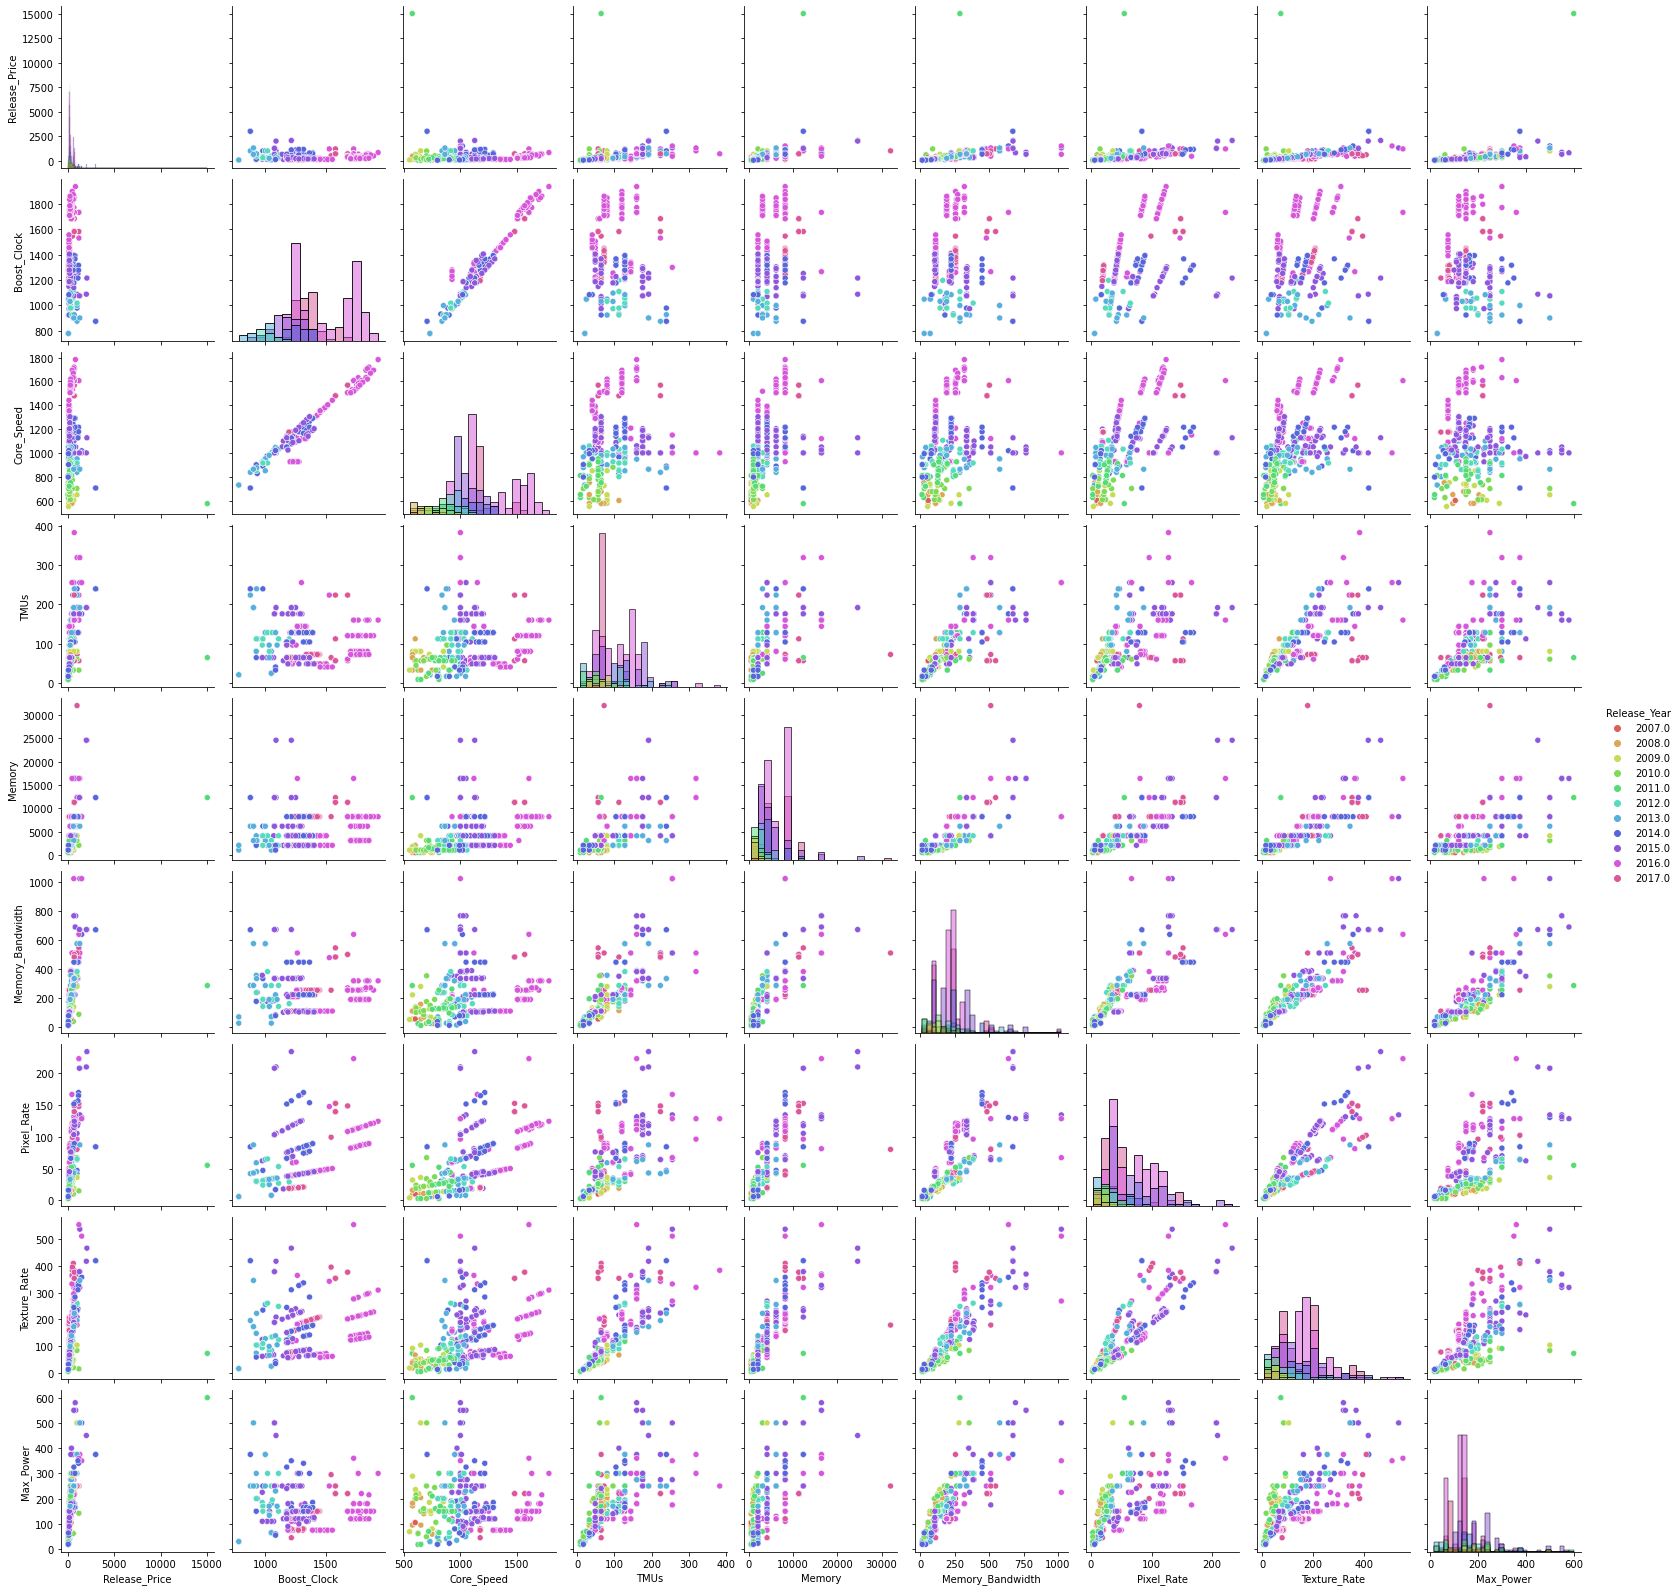

In [14]:
sns.pairplot(df2[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We can notice that for Release_Price there are some outliers in the data that are skewing the scatterplots. Let's remove these outliers.

In [15]:
release_price = df2['Release_Price']

In [16]:
release_price.describe()

count      556.000000
mean       371.562446
std        698.262897
min         23.000000
25%        159.750000
50%        240.000000
75%        421.500000
max      14999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

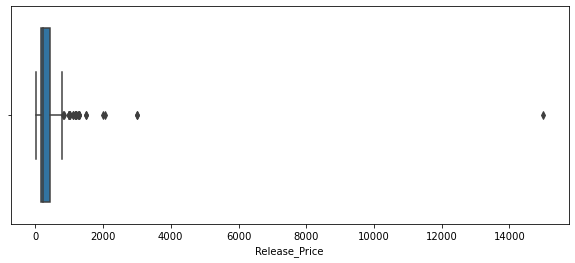

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=release_price, ax=ax)

We take the release prices in the range of 5% quantile and 95% quantile.

In [18]:
release_price_adjusted_mask = release_price.between(release_price.quantile(0.05), release_price.quantile(0.95))

In [19]:
df3 = df2[release_price_adjusted_mask].copy().reset_index(drop=True)

In [20]:
df3['Release_Price'].describe()

count    509.000000
mean     312.272652
std      201.803485
min       99.000000
25%      174.000000
50%      240.000000
75%      398.000000
max      999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

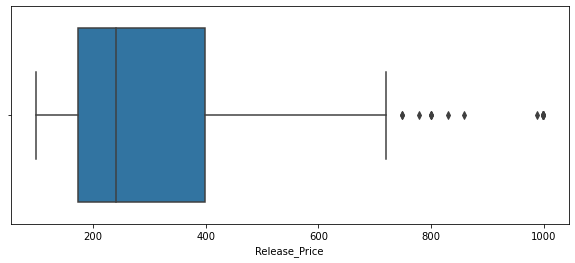

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df3['Release_Price'], ax=ax)

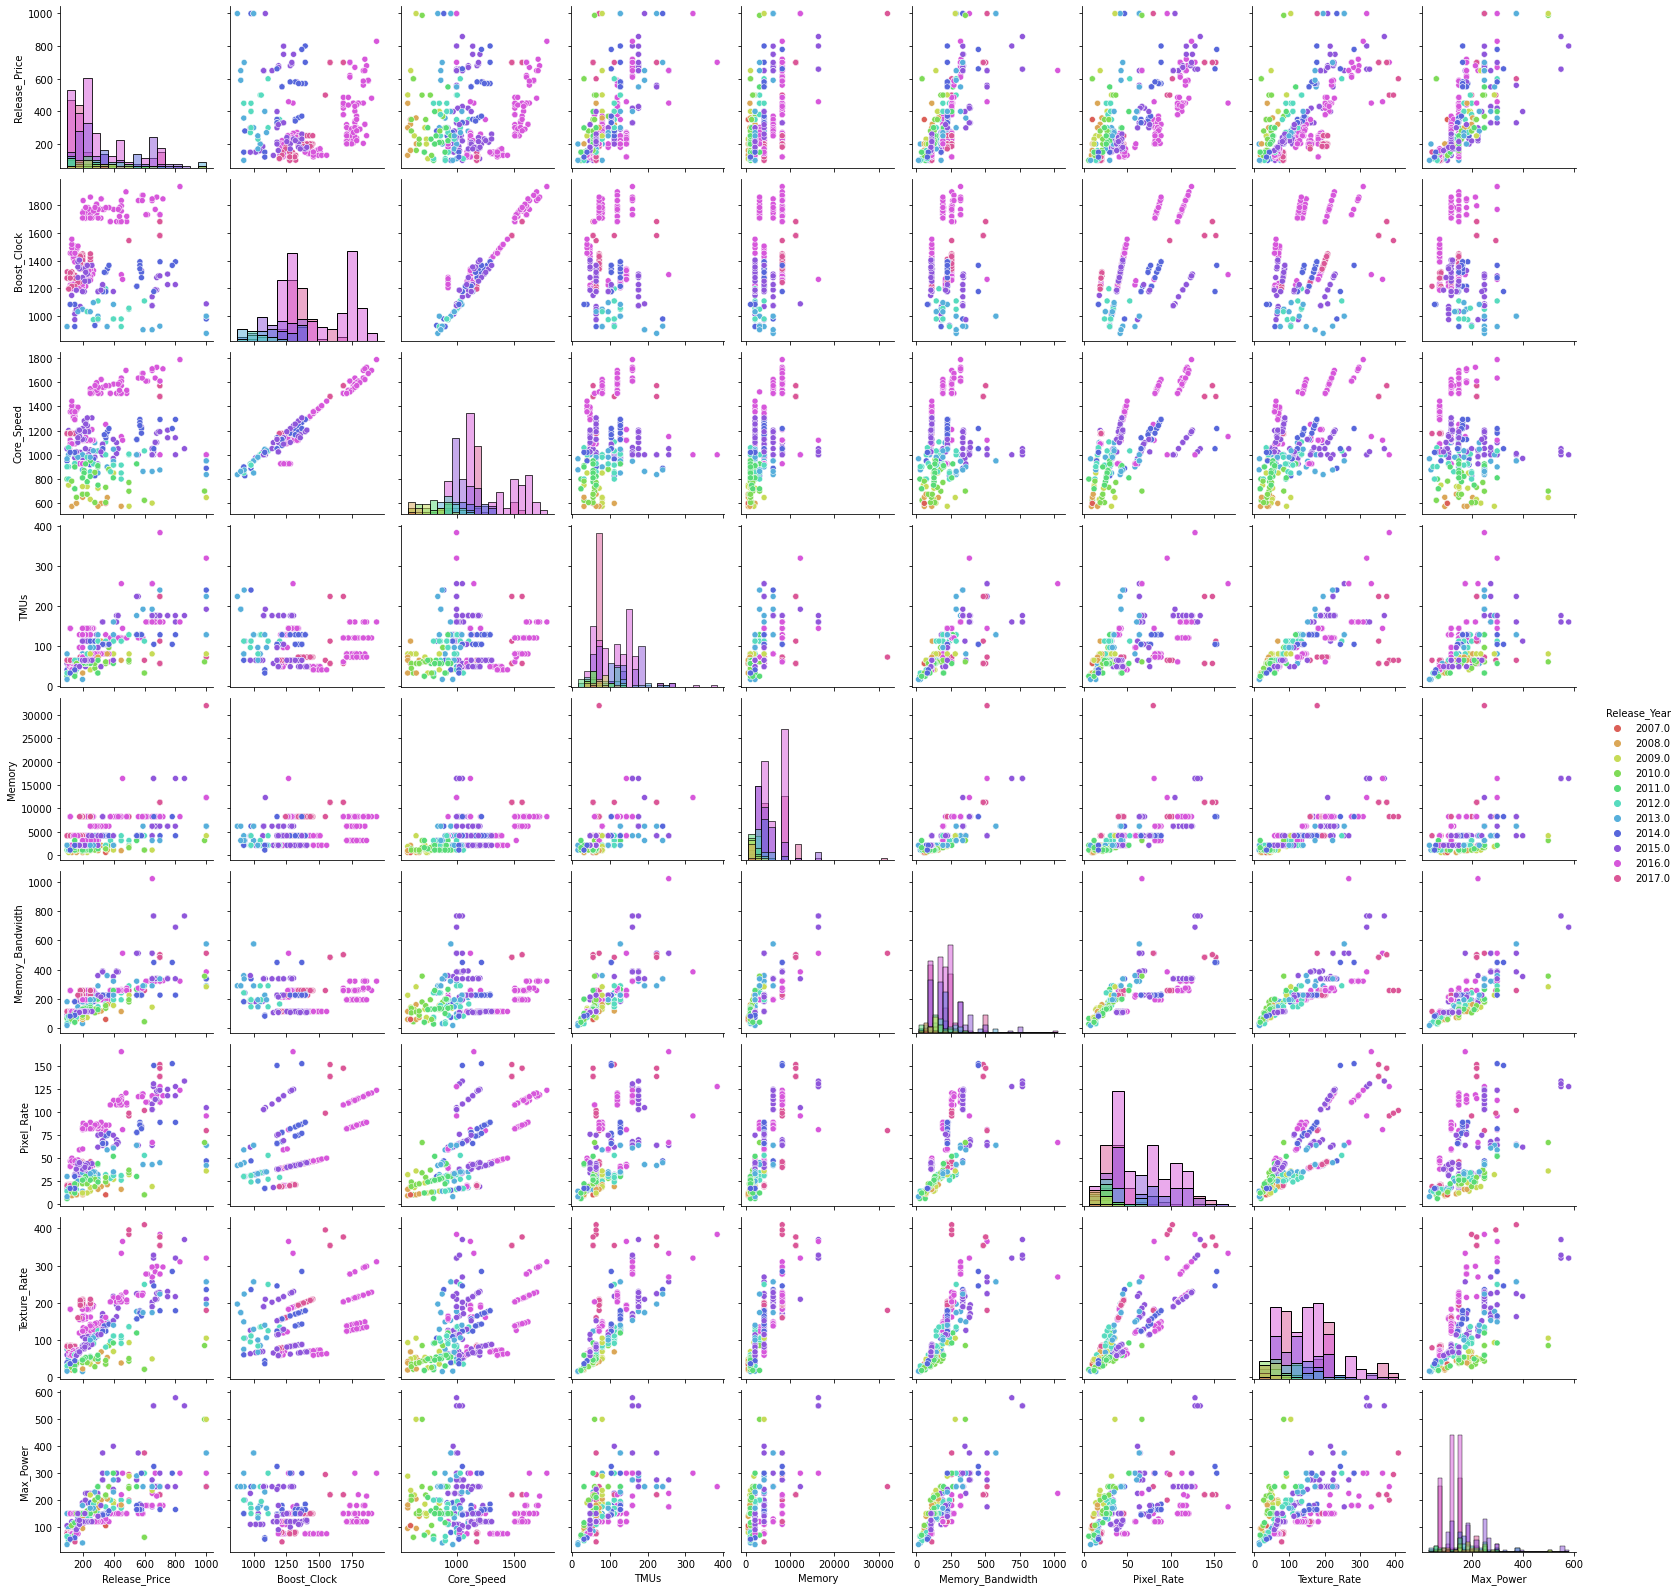

In [22]:
sns.pairplot(df3[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We now have a better visualization of Release_Price

<AxesSubplot:>

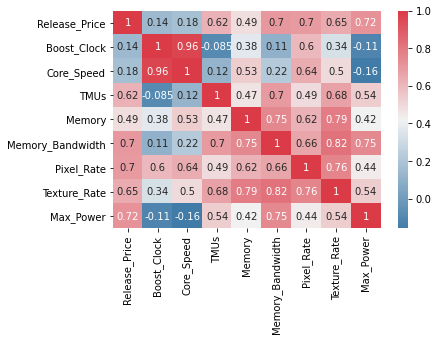

In [23]:
corr = df3[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Since Release_Price stays the same for yearly releases of GPUs but the performance get's better by year as GPUs improve, let's see the pairplot and heatmap for a single year.

<AxesSubplot:xlabel='Release_Year', ylabel='Count'>

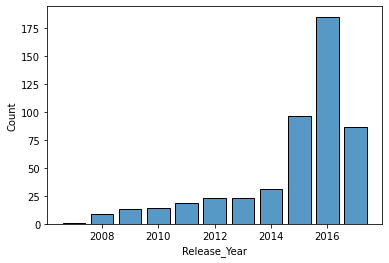

In [24]:
sns.histplot(df3['Release_Year'], discrete=True, shrink=0.8)

In [25]:
df3['Release_Year'].value_counts()

2016.0    185
2015.0     96
2017.0     87
2014.0     31
2013.0     23
2012.0     23
2011.0     19
2010.0     14
2009.0     13
2008.0      9
2007.0      1
Name: Release_Year, dtype: int64

We will choose 2016 since it has the largest number of releases.

In [26]:
df4 = df3[df3['Release_Year'] == 2016].copy().reset_index(drop=True)

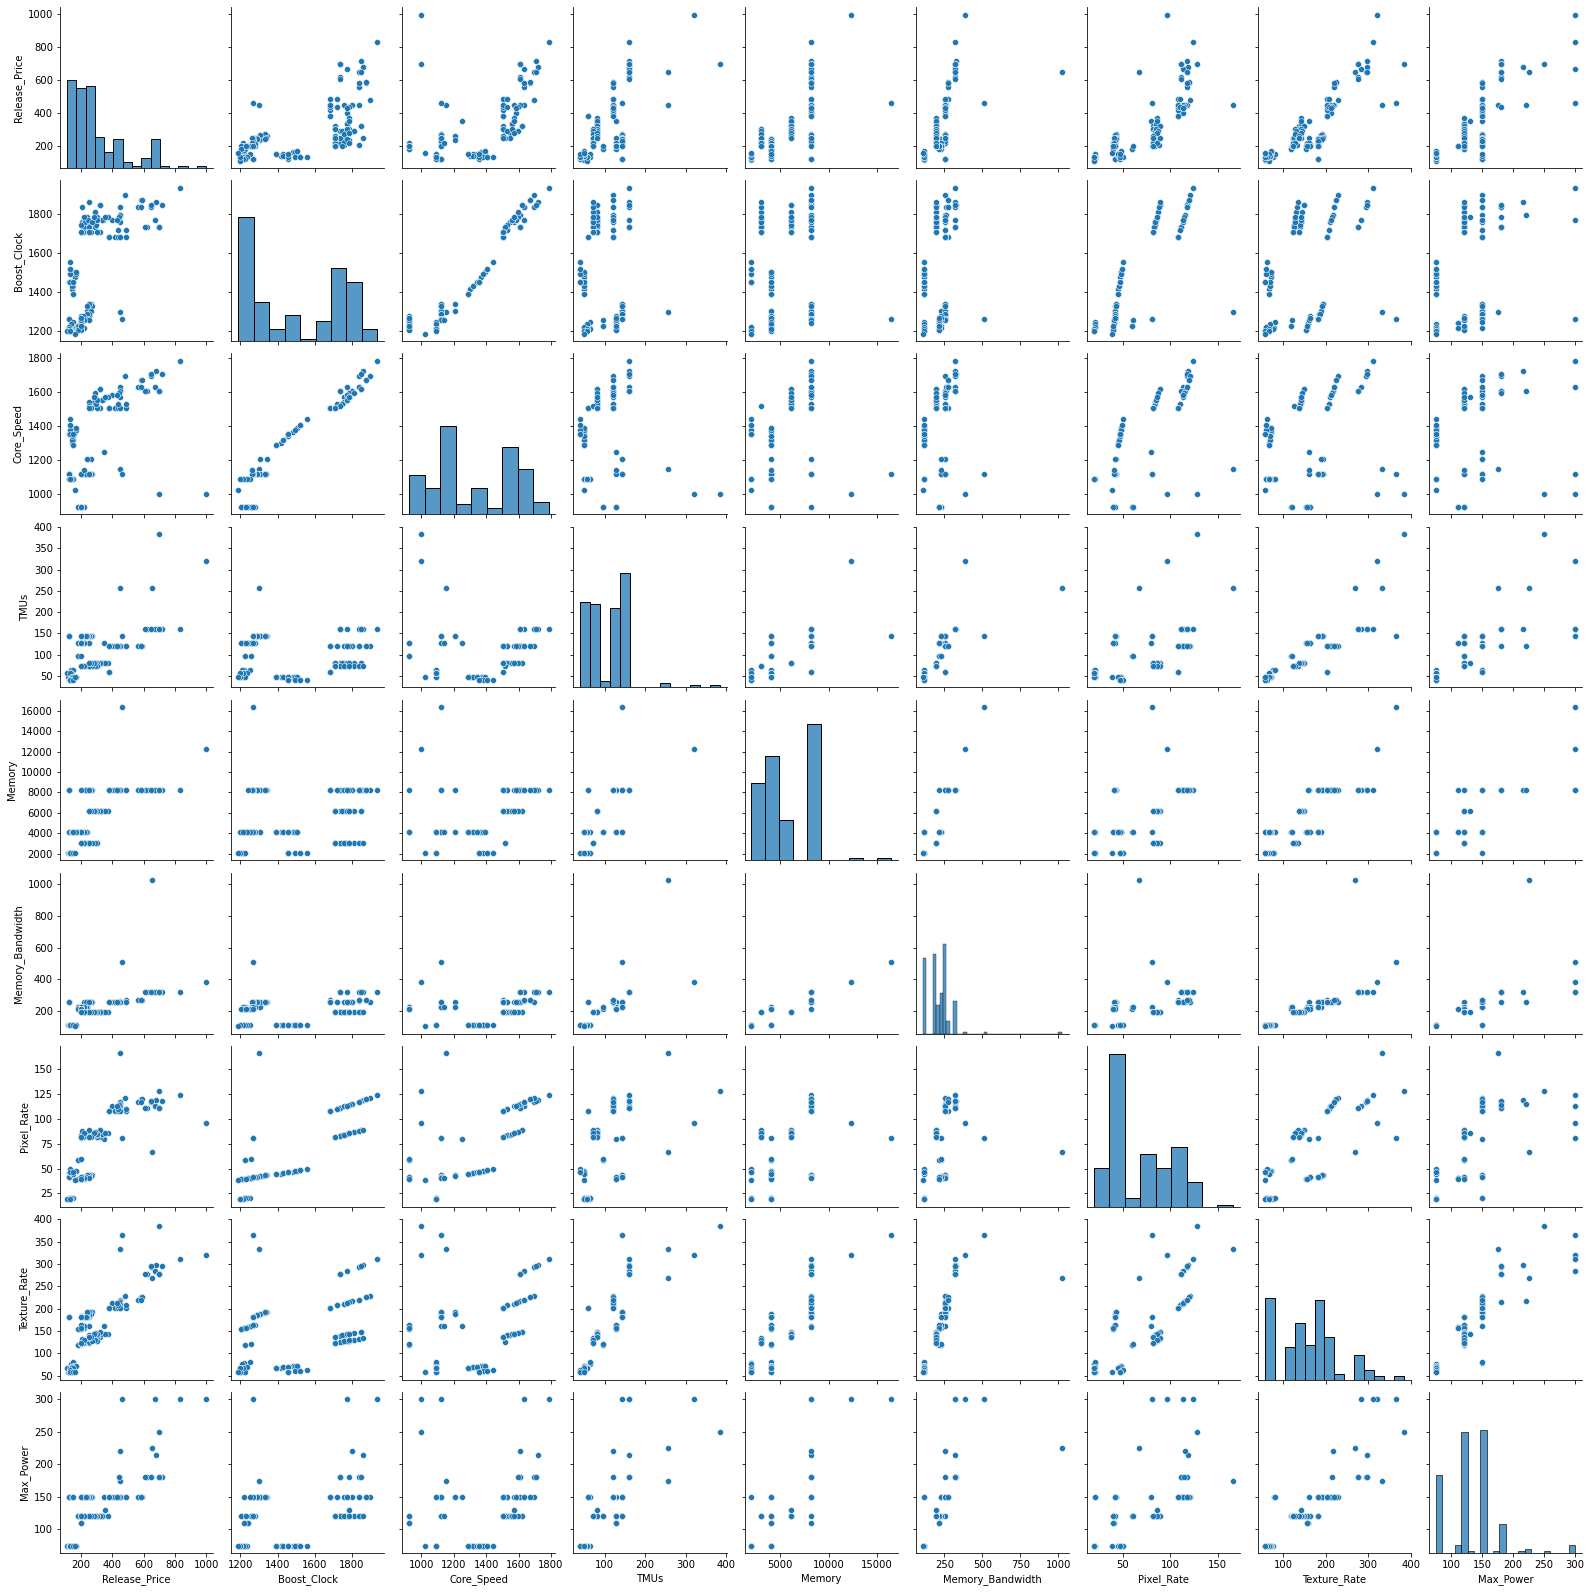

In [27]:
sns.pairplot(df4[regression_columns], diag_kind="hist")

<AxesSubplot:>

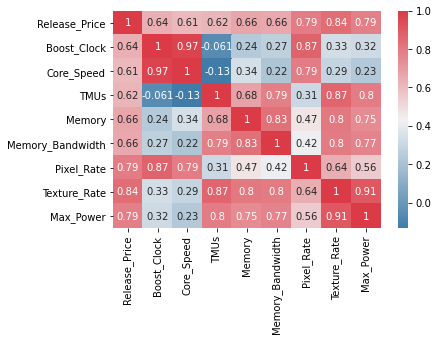

In [28]:
corr = df4[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Correlation between the variables has significantly increased now that we limited the Release_Year.

### Linear regression

In [29]:
import statsmodels.api as sm
from yellowbrick.regressor import CooksDistance

#### All years

##### x=Texture_Rate, y=Release_Price

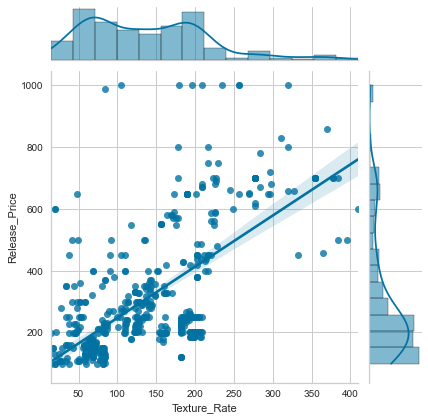

In [30]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df3, kind='reg')

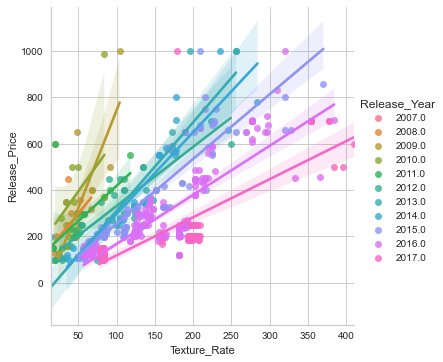

In [31]:
sns.lmplot(x='Texture_Rate', y='Release_Price', data=df3, hue='Release_Year')

We can notice a pattern in the plot, that the more recent the year, the lower the linear regression line is. This means that as GPUs advance we get higher texture rates for lower release prices.

##### x=Pixel_Rate, y=Release_Price

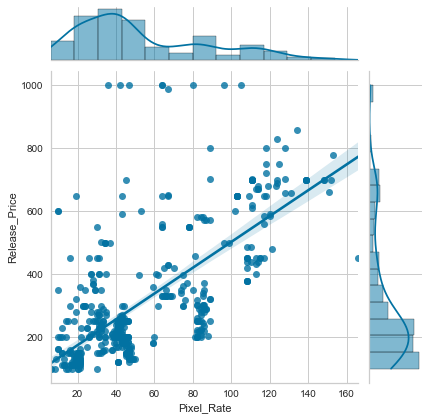

In [32]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df3, kind='reg')

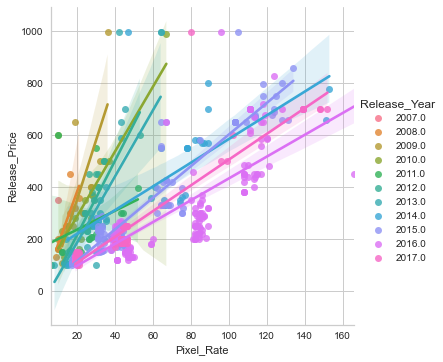

In [33]:
sns.lmplot(x='Pixel_Rate', y='Release_Price', data=df3, hue='Release_Year')

##### x=Memory_Bandwidth, y=Release_Price

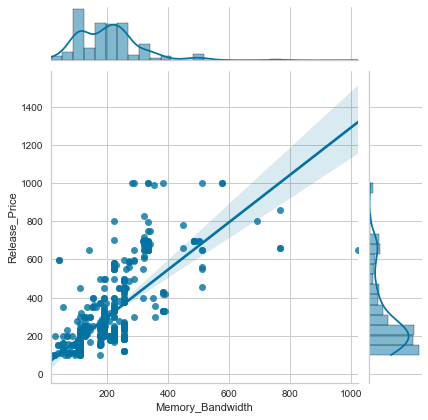

In [34]:
sns.jointplot(x='Memory_Bandwidth', y='Release_Price', data=df3, kind='reg')

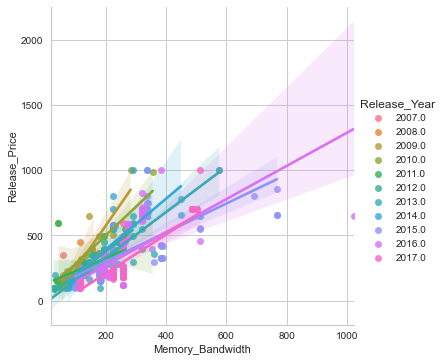

In [35]:
sns.lmplot(x='Memory_Bandwidth', y='Release_Price', data=df3, hue='Release_Year')

##### x=Max_Power, y=Release_Price

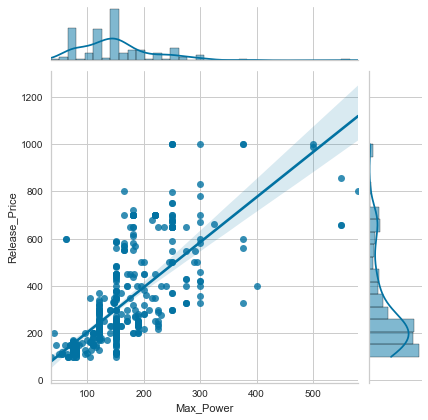

In [36]:
sns.jointplot(x='Max_Power', y='Release_Price', data=df3, kind='reg')

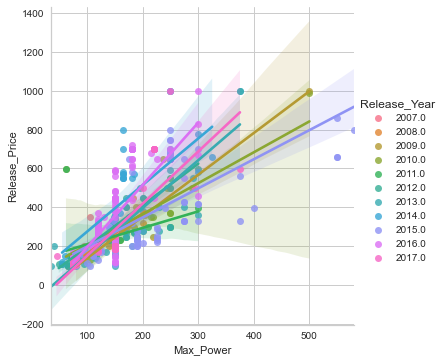

In [37]:
sns.lmplot(x='Max_Power', y='Release_Price', data=df3, hue='Release_Year')

#### 2016

##### x=Texture_Rate, y=Release_Price

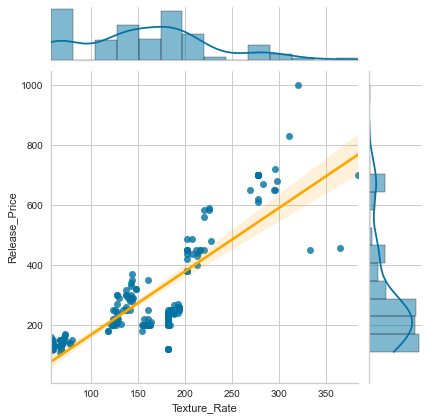

In [38]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df4, kind='reg', line_kws={'color': 'orange'})

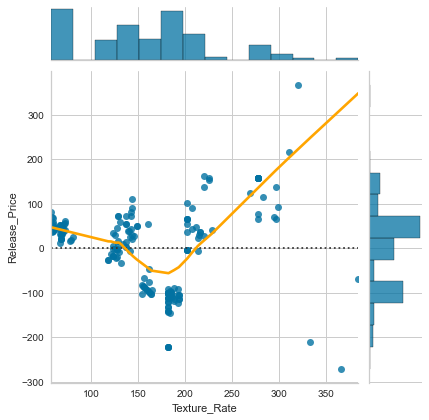

In [39]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df4, kind='resid', lowess=True, line_kws={'color': 'orange'})

In [40]:
regressor1 = sm.OLS(df4['Release_Price'], df4[['Texture_Rate']]).fit()
regressor1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              2166.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                   1.03e-103
Time:                        06:11:10   Log-Likelihood:                         -1106.8
No. Observations:                 185   AIC:                                      2216.
Df Residuals:                     184   BIC:                                      2219.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Texture_Rate     1.8850      0.041     46.539      0.000       1.805       1.965
==============================================================================
Omnibus:                       11.133   Durbin-Watson:                   0.408
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.729
Skew:                           0.402   Prob(JB):                     0.000633
Kurtosis:                       4.125   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We make sure that the linear model from this library is similar to the previous one.

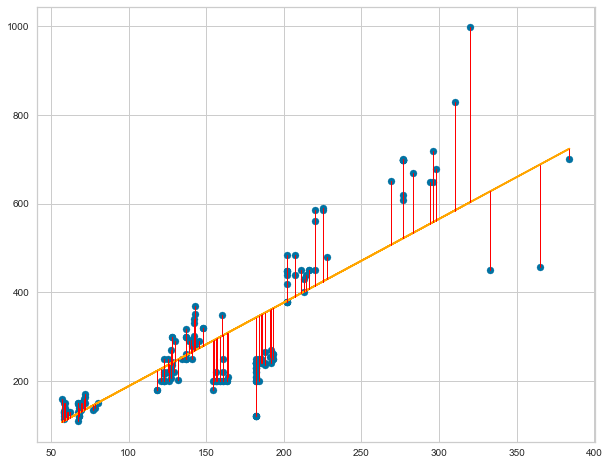

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(df4['Texture_Rate'], df4['Release_Price'])
predictions = regressor1.predict(df4['Texture_Rate'])
plt.plot(df4['Texture_Rate'], predictions, c='orange')
for x, y_real, y_predict in zip(df4['Texture_Rate'], df4['Release_Price'], predictions):
    plt.plot([x, x], [y_real, y_predict], c='red', lw=1)

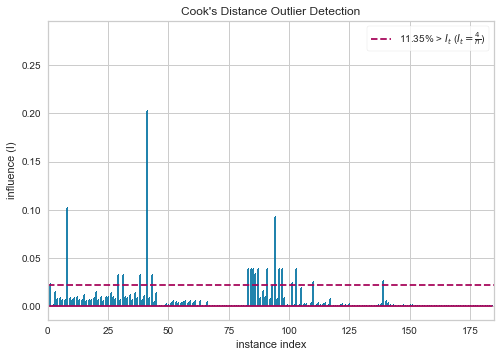

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [42]:
visualizer = CooksDistance()
visualizer.fit(df4[['Texture_Rate']], df4['Release_Price'])
visualizer.show()

To show an example let's use the data without the removed outliers and let's visualize it with Cook's D plot.

In [43]:
df5 = df2[df2['Release_Year'] == 2016].copy().reset_index(drop=True)

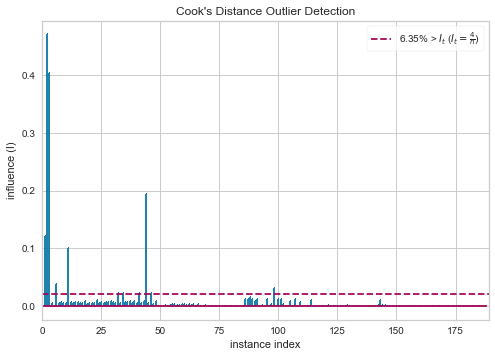

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [44]:
visualizer = CooksDistance()
visualizer.fit(df5[['Texture_Rate']], df5['Release_Price'])
visualizer.show()

From seeing both plots we could conclude that we removed a large portion of the outliers from the original data. Further investigation would need to be made in order to find out the cause of these outliers. I suppose that it is due to expensive server/workstation GPUs that don't provide much more texture fillrate, but rather provide server grade features useful only in datacenters, hence their larger release price.  
So I can comfortably say that we are not throwing out very important data, because these models of GPUs are rare and produced in small quantities for datacenters.

##### x=Pixel_Rate, y=Release_Price

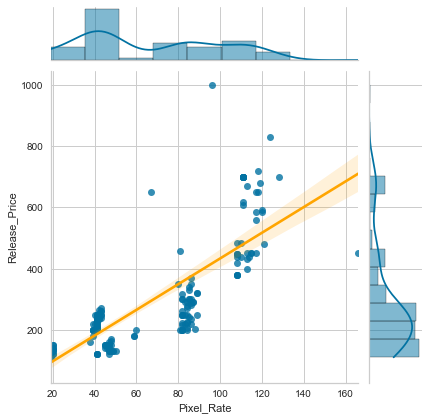

In [45]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df4, kind='reg', line_kws={'color': 'orange'})

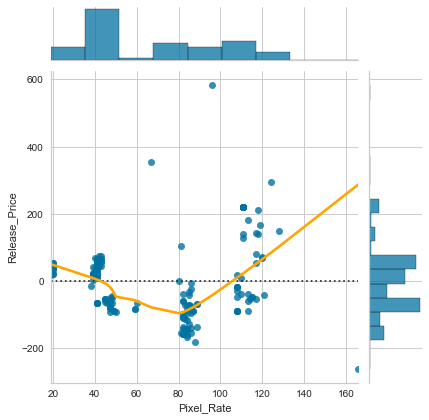

In [46]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df4, kind='resid', lowess=True, line_kws={'color': 'orange'})

In [47]:
regressor2 = sm.OLS(df4['Release_Price'], df4[['Pixel_Rate']]).fit()
regressor2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              1722.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    2.45e-95
Time:                        06:11:12   Log-Likelihood:                         -1126.1
No. Observations:                 185   AIC:                                      2254.
Df Residuals:                     184   BIC:                                      2257.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pixel_Rate     4.3589      0.105     41.494      0.000       4.152       4.566
==============================================================================
Omnibus:                       56.760   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.161
Skew:                           1.202   Prob(JB):                     2.28e-41
Kurtosis:                       7.301   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

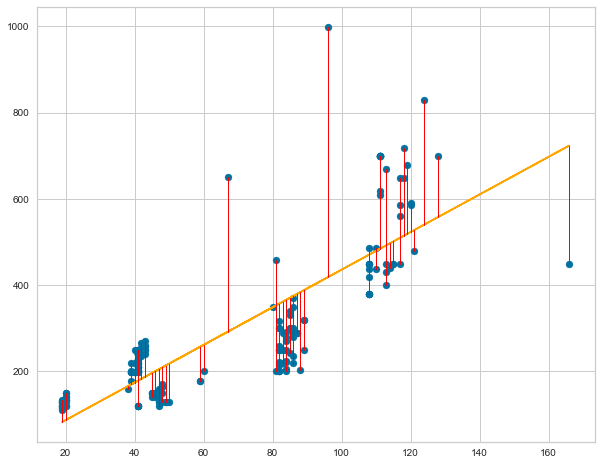

In [48]:
plt.figure(figsize=(10, 8))
plt.scatter(df4['Pixel_Rate'], df4['Release_Price'])
predictions = regressor2.predict(df4['Pixel_Rate'])
plt.plot(df4['Pixel_Rate'], predictions, c='orange')
for x, y_real, y_predict in zip(df4['Pixel_Rate'], df4['Release_Price'], predictions):
    plt.plot([x, x], [y_real, y_predict], c='red', lw=1)

### Multivariable linear regression

For multivariable linear regression we need to use predictors that have a low correlation. For that we need to take a look at the heatmap from earlier. I chose Core_Speed and Max_Power because they have a correlation of 0.23.

In [59]:
df5 = df4[df4['Core_Speed'].notna() & df4['Max_Power'].notna()].copy().reset_index(drop=True)
df5

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection,Release_Year
0,Pascal P100,3840 x 2160,NaN,1000.0,1.0,Yes,DX 12.1,3.0,1.0,No,...,96,\n17-Aug-2016,999.00,7680x4320,Yes,5.0,320.0,320.0,0.0,2016.0
1,GCN 1.3 Ellesmere XT,NaN,NaN,1250.0,1.0,NaN,DX 12.0,3.0,1.0,NaN,...,64,\n01-Nov-2016,349.00,4096x2160,Yes,NaN,128.0,160.0,0.0,2016.0
2,GCN 1.3 Polaris 10,NaN,NaN,1000.0,2.0,NaN,DX 12.1,3.0,1.0,NaN,...,128,\n01-Jun-2016,699.99,4096x2160,Yes,NaN,384.0,384.0,0.0,2016.0
3,GCN 1.3 Ellesmere XT,2560 x 1440,1288.0,1120.0,0.0,Yes,DX 12.0,3.0,1.0,No,...,32,\n29-Jun-2016,245.00,4096x2160,No,5.0,144.0,185.0,0.0,2016.0
4,GCN 1.3 Ellesmere XT,2560 x 1440,1338.0,1120.0,1.0,Yes,DX 12.0,3.0,1.0,No,...,32,\n29-Jul-2016,260.00,4096x2160,No,5.0,144.0,193.0,0.0,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Pascal P107,1600 x 900,1518.0,1404.0,1.0,Yes,DX 12.1,1.0,1.0,No,...,32,\n01-Nov-2016,130.00,7680x4320,No,5.0,40.0,61.0,0.0,2016.0
153,Pascal P107,1600 x 900,1556.0,1442.0,1.0,Yes,DX 12.1,1.0,1.0,No,...,32,\n01-Nov-2016,130.00,7680x4320,No,5.0,40.0,62.0,0.0,2016.0
154,Pascal P107,1600 x 900,1455.0,1354.0,1.0,Yes,DX 12.1,1.0,1.0,No,...,32,\n01-Nov-2016,130.00,7680x4320,No,5.0,40.0,58.0,0.0,2016.0
155,Pascal P107,1600 x 900,1455.0,1354.0,1.0,Yes,DX 12.1,1.0,1.0,No,...,32,\n01-Nov-2016,150.00,7680x4320,Yes,5.0,40.0,58.0,0.0,2016.0


In [60]:
regressor3 = sm.OLS(df5['Release_Price'], df5[['Core_Speed', 'Max_Power']]).fit()
regressor3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Release_Price   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.884
Method:                 Least Squares   F-statistic:                              599.8
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    1.08e-73
Time:                        06:15:24   Log-Likelihood:                         -975.77
No. Observations:                 157   AIC:                                      1956.
Df Residuals:                     155   BIC:                                      1962.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Core_Speed     0.0361      0.023      1.576      0.117      -0.009       0.081
Max_Power      2.0529      0.215      9.549      0.000       1.628       2.478
==============================================================================
Omnibus:                       26.257   Durbin-Watson:                   0.470
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.411
Skew:                           1.078   Prob(JB):                     5.56e-08
Kurtosis:                       3.676   Cond. No.                         29.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Residuals

Let's manually plot the residuals

In [70]:
predicted = regressor3.predict(df5[['Core_Speed', 'Max_Power']])
actual = df5['Release_Price']
residual = actual - predicted
residual

0      346.994129
1       -4.099943
2      150.630217
3     -103.403128
4      -88.403128
          ...    
152    -74.694730
153    -76.067645
154    -72.888263
155    -52.888263
156    -31.965579
Length: 157, dtype: float64

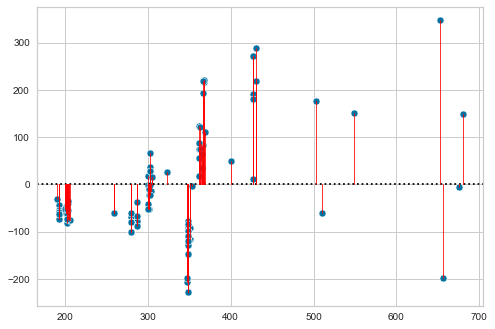

In [89]:
sns.scatterplot(x=predicted, y=residual)
plt.axhline(0, c='black', linestyle=':')
for x_predict, y_residual in zip(predicted, residual):
    plt.plot([x_predict, x_predict], [0, y_residual], c='red', lw=1, alpha=0.8)